# Download Any OSM Geospatial Features with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

More info:

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)
  
This notebook provides a quick tour of using OSMnx to download any geospatial features from OpenStreetMap as a geopandas GeoDataFrame.

In [11]:
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.2'

Use the `geometries` module to download features, such as grocery stores, transit stops, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries).

To query, pass a `tags` dict where keys are OSM tags. The dict's values can be either:
  1. `True` to retrieve all OSM objects with this tag, regardless of its value
  2. a single value as a string to retrieve all OSM objects with this tag:value combination
  3. a list of string values to retrieve all OSM objects where this tag matches any of these values

Pass multiple dict key:value pairs to retrieve the union (not intersection) of these pairs.

In [12]:
# get all building footprints in some neighborhood
# `True` means retrieve any object with this tag, regardless of value
place = "Chinatown, San Francisco, California"
tags = {"building": True}
gdf = ox.features.features_from_place(place, tags)
gdf.shape

(568, 105)

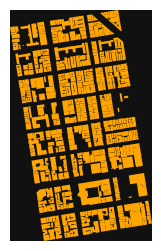

In [13]:
fig, ax = ox.plot.plot_footprints(gdf, figsize=(3, 3))

In [14]:
# get all the parks in some neighborhood
# constrain acceptable `leisure` tag values to `park`
tags = {"leisure": "park"}
gdf = ox.features.features_from_place(place, tags)
gdf.shape

(2, 17)

In [15]:
# get everything tagged amenity,
# and everything tagged landuse = retail or commercial,
# and everything tagged highway = bus_stop
tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.features.features_from_place("Piedmont, California, USA", tags)
gdf.shape

(162, 70)

In [16]:
# view just the banks
gdf[gdf["amenity"] == "bank"].dropna(axis=1, how="any")

geometry amenity  \
element id                                                                      
node    2810181540                        POINT (-122.23256 37.82515)    bank   
way     276424028   POLYGON ((-122.23259 37.82492, -122.23252 37.8...    bank   
        285549437   POLYGON ((-122.23148 37.82467, -122.23133 37.8...    bank   

                               name            brand brand:wikidata  
element id                                                           
node    2810181540         Citibank         Citibank        Q857063  
way     276424028   Bank of America  Bank of America        Q487907  
        285549437       Wells Fargo      Wells Fargo        Q744149

In [17]:
# view just the bus stops
gdf[gdf["highway"] == "bus_stop"].dropna(axis=1, how="any").head()

geometry  \
element id                                        
node    4071030440  POINT (-122.21517 37.81248)   
        5845148873  POINT (-122.21492 37.81822)   
        5845152990  POINT (-122.21459 37.81818)   
        5845153014  POINT (-122.22303 37.81763)   
        5845153034  POINT (-122.22265 37.81779)   

                                                  name  bus   highway  \
element id                                                              
node    4071030440  Park Boulevard & Saint James Drive  yes  bus_stop   
        5845148873     Hampton Road & Sandringham Road  yes  bus_stop   
        5845152990     Hampton Road & Sandringham Road  yes  bus_stop   
        5845153014       Hampton Road & Seaview Avenue  yes  bus_stop   
        5845153034       Hampton Road & Seaview Avenue  yes  bus_stop   

                       network public_transport    ref route_ref  
element id                                                        
node    4071030440  AC Transit         platform  57544  V;33;688  
        5845148873  AC Transit         platform  53832        33  
        5845152990  AC Transit         platform  50830        33  
        5845153014  AC Transit         platform  53865        33  
        5845153034  AC Transit         platform  53238        33

## Attach features to nearest nodes

For example, attach parking information to nearest network nodes.

In [18]:
# first create the graph and the features
place = "Piedmont, CA, USA"
G = ox.graph.graph_from_place(place, network_type="drive")
features = ox.features.features_from_place(place, {"amenity": "parking"})

In [19]:
# then attach your features to your graph's nearest nodes as attributes
feature_points = features.representative_point()
nn = ox.distance.nearest_nodes(G, feature_points.x, feature_points.y)
useful_tags = ["access", "parking", "surface", "capacity", "fee"]
for node, feature in zip(nn, features[useful_tags].to_dict(orient="records")):
    feature = {k: v for k, v in feature.items() if pd.notna(v)}
    G.nodes[node].update({"parking": feature})